In [3]:
import numpy as np
import math
import pandas as pd
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from netCDF4 import Dataset

from sklearn.preprocessing import MinMaxScaler


import PCA_functions as pf
import Extreme_functions as ef

from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, CMIknn
import tigramite.data_processing as pp

from Data import Data
from datetime import datetime

import pickle
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

In [4]:
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

def deseasonalize(data,freq=12):
    """
    The shape of data should be (time, index) 
    """
    n  = data.shape[1]
    N  = data.shape[0]
    data_deseasonal = np.zeros(data.shape)
    for i in range(n):
        temp = np.copy(data[:,i])
        r = np.zeros((N))
        for j in range(freq):
            Idx = np.arange(j,N,freq)
            if temp[Idx].std() == 0:
                r[Idx] = 0
            else:
                r[Idx] = (temp[Idx] - temp[Idx].mean())/temp[Idx].std()
        data_deseasonal[:,i] = np.copy(r)
    return(data_deseasonal)


ET_gamma = np.load("ET_gamma.npy")
N = ET_gamma.shape[0]
n_nodes = ET_gamma.shape[1]
extremes_treshold = -1
count = []
for i in range(N):
    count.append(np.count_nonzero(ET_gamma[i,:] <= extremes_treshold))

level = 12
temporal_limits = {"time_min":datetime(1977, 1, 1, 0, 0),"time_max":datetime(2015, 12, 1, 0, 0) }

In [29]:
name = ["../../nc/sst.mnmean.nc","../../nc/air.mon.mean.nc","../../nc/precip.mon.total.2.5x2.5.v2018.nc","../../nc/pres.mon.mean.nc"]
code = ["sst","air","precip", "pres"]
missing = [-9.96921e+36,-9.96921e+36,-9.96921e+36,-9.96921e+36]
n_components = [76, 82,87, 64]

df_cluster = []
loading_list = []
for j in range(len(name)):
    d = Data('{}'.format(name[j]),code[j],temporal_limits,missing_value=missing[j])

    result = d.get_data()
    lon_list = d.get_lon_list()
    lat_list = d.get_lat_list()
    lon = d.get_lon()
    lat = d.get_lat()

    result = deseasonalize(np.array(result))
    weights = np.sqrt(np.abs(np.cos(np.array(lat_list)* math.pi/180)))
    for i in range(len(weights)):
        result[:,i] = weights[i] * result[:,i]

    data = pd.DataFrame(result)
    pca = PCA(n_components=n_components[j])
    pca_model = pca.fit(data)

    df_cluster.append(pca_model.transform(data))
    
    loading = np.transpose(pca_model.components_) 
    loading_list.append(pd.DataFrame(loading)) 

extremes_name  = ["n_extremes"]

#precip_name  = []
#for i in range(n_components[0]):
#    precip_name.append("PRECIP_%d"%i)

#pres_name  = []
#for i in range(n_components[1]):
#    pres_name.append("PRES_%d"%i)

sst_name  = []
for i in range(n_components[0]):
    sst_name.append("SST_%d"%i)

sat_name  = []
for i in range(n_components[1]):
    sat_name.append("SAT_%d"%i)

In [4]:
result_sst = np.array(df_cluster[0])
result_sat = np.array(df_cluster[1])

In [41]:
link_lists = []

results_file = ["results_st", "results_sat", "results_pre", "results_pres"]
names = ["SST", "SAT", "Precip", "Press"]

for file  in results_file:
    results_file = load_obj(file)
    pq_matrix = results_file['p_matrix']
    val_matrix = results_file['val_matrix']
    alpha_level = 0.05
    N = pq_matrix.shape[0]

    link_dict = dict()
    for j in range(N):
        # Get the good links
        good_links = np.argwhere(pq_matrix[:, j, 1:] <= alpha_level)
        # Build a dictionary from these links to their values
        links = {(i, -tau - 1): np.abs(val_matrix[i, j, abs(tau) + 1])
                 for i, tau in good_links}
        # Sort by value
        link_dict[j] = sorted(links, key=links.get, reverse=True)
    link = np.array(link_dict[0])
    link_lists.append(link[1:,: ])


In [43]:
n_estimators=100
max_depth=100
tau = -6

In [44]:
def min_MSE_finder(count, df_cluster, link_lists, n_estimators=100, max_depth=5, tau=-1):
    result = []
    name = []

    df = pd.DataFrame({"drought":count, "drought1":count})
    df.drought1 = df.drought1.shift(abs(tau))
    df = df.dropna()
    index = int(df.shape[0]*0.8)
    dim = df.shape[1]

    x_train, x_test = df.iloc[:index,1:dim], df.iloc[index:,1:dim] 
    y_train, y_test = df.iloc[:index,0], df.iloc[index:,0] 
    model = RandomForestRegressor(max_depth=max_depth, random_state=0, n_estimators=n_estimators)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    result.append(mean_squared_error(y_pred, y_test))
    
    #name.append("Drought")

    
    for p in range(len(df_cluster)):
        link = link_lists[p]
        link = link[link[:,1] <= tau]
        link_lists[p] = link
        for z in range(len(link)):
            df = pd.DataFrame({"drought":count, "drought1":count})
            df.drought1 = df.drought1.shift(abs(tau))
            for k in range(0,z+1):
                if link[k,0] != 0:
                    df[str(link[k,0]-1 + p*len(link))] = df_cluster[p][:,link[k,0]-1]
                    df[str(link[k,0]-1 + p*len(link))] = df[str(link[k,0]-1+ p*len(link))].shift(abs(link[k,1]))
                #else:
                #    df[str(link[k,0])] = count
                #    df[str(link[k,0])] = df[str(link[k,0])].shift(abs(link[k,1]))
            #name.append(names[p]+str(link[z,0]-1))
            df = df.dropna()
            index = int(df.shape[0]*0.8)
            dim = df.shape[1]

            x_train, x_test = df.iloc[:index,1:dim], df.iloc[index:,1:dim] 
            y_train, y_test = df.iloc[:index,0], df.iloc[index:,0] 
            model = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=100)
            model.fit(x_train, y_train)
            y_pred = model.predict(x_test)
            result.append(mean_squared_error(y_pred, y_test))
    return(result,link_lists)

In [45]:
result, link = min_MSE_finder(count, df_cluster, link_lists, n_estimators, max_depth,tau)

In [46]:
overall_min_MSE = []
overall_min_MSE.append(min(result))

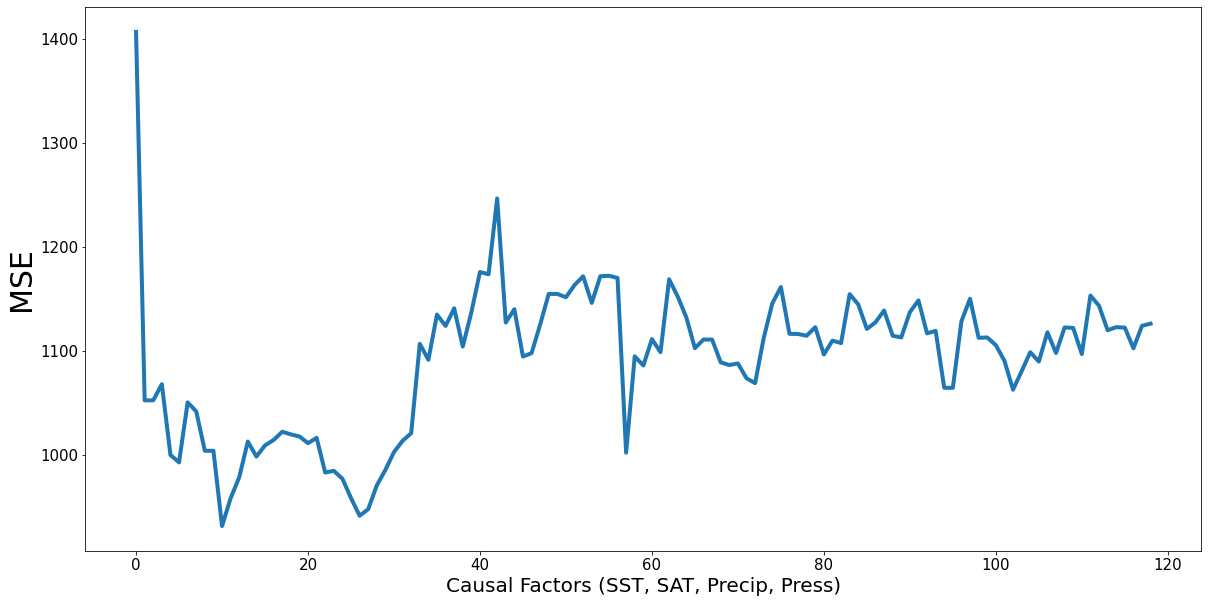

In [47]:
plt.plot(result,linewidth=4.0)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel("MSE",fontsize = 30)
plt.xlabel("Causal Factors (SST, SAT, Precip, Press)",fontsize = 20)
plt.savefig("Errors.png")

In [48]:
def link_refiner(link_lists, I):
    start = 0
    for j in range(len(link_lists)):
        link_lists[j] = link_lists[j][I[start:start + len(link_lists[j])],:]
        start += len(link_lists[j])
    return(link_lists)
    

In [49]:
link_list = []
diff = [x - result[i - 1] for i, x in enumerate(result)][1:]
I = np.array(diff) < 0 

In [50]:
while not all(I):
    link_list.append(link_lists)
    link_lists = link_refiner(link_lists, I)
    result, link_lists = min_MSE_finder(count, df_cluster, link_lists, n_estimators, max_depth,tau)
    overall_min_MSE.append(min(result))
    diff = [x - result[i - 1] for i, x in enumerate(result)][1:]
    I = np.array(diff) < 0

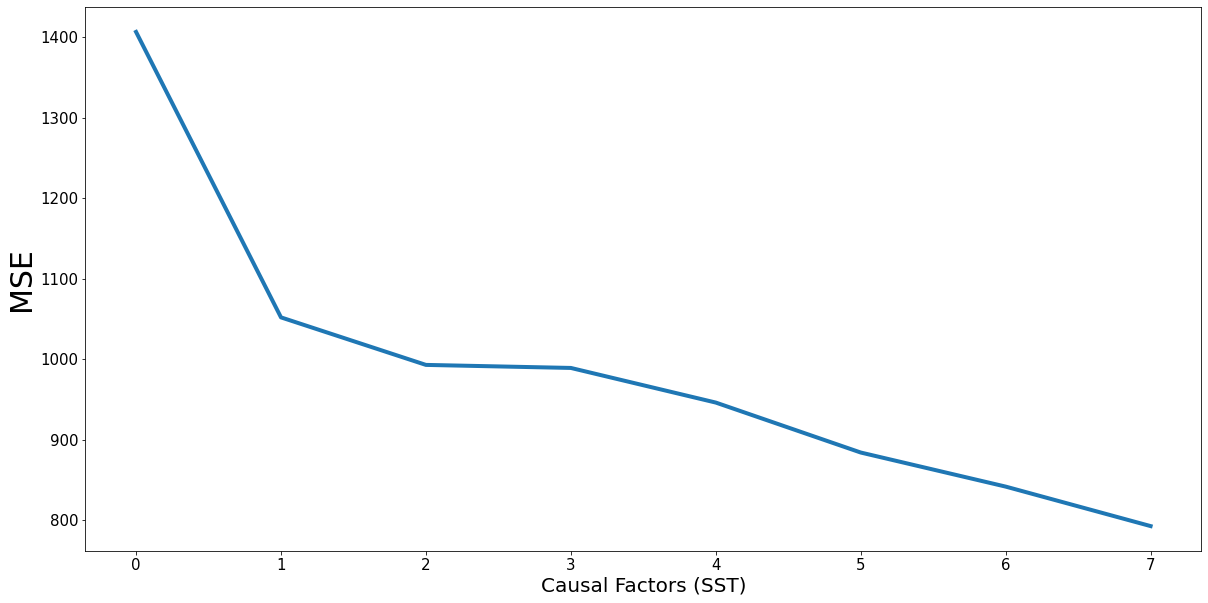

In [53]:
plt.plot(result,linewidth=4.0)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel("MSE",fontsize = 30)
plt.xlabel("Causal Factors (SST)",fontsize = 20)
plt.savefig("Errors_final.png")

In [54]:
link_lists

[array([[  2, -12],
        [ 22,  -8],
        [ 38,  -8],
        [ 54,  -6],
        [ 14,  -6],
        [ 33,  -8],
        [ 57,  -6]]),
 array([], shape=(0, 2), dtype=int64),
 array([], shape=(0, 2), dtype=int64),
 array([], shape=(0, 2), dtype=int64)]

In [55]:
overall_min_MSE

[931.1512378707328,
 859.0571224137359,
 818.7539340318665,
 792.9807154520374,
 792.9807154520374,
 792.9807154520374]

In [5]:
def time_series_maker(pc, df_sst, result, level = 95): 
    limit = np.percentile(df_sst.pc.values, level)
    d = df_sst[df_sst.pc > limit]
    d = result[:,d.index].mean(axis=1)
    d = np.ravel(d)
    d = np.reshape(d,(len(d),1))
    d = pf.deseasonalize(d)
    d = np.ravel(d)
    return(d)

In [ ]:
name = ["../../nc/sst.mnmean.nc","../../nc/air.mon.mean.nc","../../nc/precip.mon.total.2.5x2.5.v2018.nc","../../nc/pres.mon.mean.nc"]
code = ["sst","air","precip", "pres"]
missing = [-9.96921e+36,-9.96921e+36,-9.96921e+36,-9.96921e+36]
n_components = [76, 82,87, 64]

df_cluster = []
df_cluster_raw = []
loading_list = []
for j in range(len(name)):
    d = Data('{}'.format(name[j]),code[j],temporal_limits,missing_value=missing[j])

    result = d.get_data()
    df_cluster_raw.append(result)
    lon_list = d.get_lon_list()
    lat_list = d.get_lat_list()
    lon = d.get_lon()
    lat = d.get_lat()

    result = deseasonalize(np.array(result))
    weights = np.sqrt(np.abs(np.cos(np.array(lat_list)* math.pi/180)))
    for i in range(len(weights)):
        result[:,i] = weights[i] * result[:,i]

    data = pd.DataFrame(result)
    pca = PCA(n_components=n_components[j])
    pca_model = pca.fit(data)

    df_cluster.append(pca_model.transform(data))
    
    loading = np.transpose(pca_model.components_) 
    loading_list.append(pd.DataFrame(loading)) 

extremes_name  = ["n_extremes"]

#precip_name  = []
#for i in range(n_components[0]):
#    precip_name.append("PRECIP_%d"%i)

#pres_name  = []
#for i in range(n_components[1]):
#    pres_name.append("PRES_%d"%i)

sst_name  = []
for i in range(n_components[0]):
    sst_name.append("SST_%d"%i)

sat_name  = []
for i in range(n_components[1]):
    sat_name.append("SAT_%d"%i)

In [25]:
file_name = 'result_dic_test_ET22222.txt'
with open(file_name, 'r') as f:
    Lines = f.readlines()
    
result = {}
for Line in Lines:
    line = Line.strip().split(")")
    key = (int(line[0].split(',')[0][1:]), int(line[0].split(',')[1].strip()))
    value = int(line[1].strip(","))
    if value >= 7:
        result[key] = value

In [19]:
file1 = open('result_dic_test_ET2222.txt', 'r') 
Lines = file1.readlines() 

In [26]:
result

{(0, -12): 9,
 (0, -11): 9,
 (0, -4): 8,
 (0, -2): 7,
 (0, -1): 9,
 (2, -12): 9,
 (26, -5): 8,
 (26, -3): 9,
 (27, -11): 9,
 (29, -2): 7,
 (34, -11): 9,
 (44, -1): 7}

In [11]:
Lines[1].split(")")[1]

',1\n'

In [13]:
Lines[1].strip().split(")")

['(23, -2', ',1']